In [14]:
from os import environ
from collections import Counter
import random
from pathlib import Path

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
from librosa import display

from medleydb.utils import get_instrument_stems, get_instruments_list

#### Create the environnement variables

In [3]:
# %env...

In [11]:
wd_path = Path.cwd() # working directory
data_path = wd_path.joinpath("data") # data directory containing the metadata.csv
img_path = wd_path.joinpath('images') # images from the 

metadata_path = wd_path.joinpath(environ['METADATA_PATH']) # medleyDB repo data path

audio_path = Path(environ['MEDLEYDB_PATH']) # medleyDB audio files path

print("wd: {},\ndata: {},\nmedleydb data: {},\naudio: {},\nimages: {}".format(wd_path, data_path, metadata_path, audio_path, img_path))

wd: D:\github\jedha-final-project\medleydb,
data: D:\github\jedha-final-project\medleydb\data,
medleydb data: D:\github\medleydb-theo\medleydb\data\Metadata,
audio: D:\Mickaël\Documents\MIR\Medley\MedleyDB\V1+2,
images: D:\github\jedha-final-project\medleydb\images


### Listing the audio files of the dataset

In [5]:
audio_files = [a.name for a in audio_path.iterdir() if a.is_dir()]

In [6]:
audio_files[:5]

['AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain']

### Listing the metadata files (yaml)

In [7]:
metadata_files = [m for m in metadata_path.glob('*.yaml')]
metadata_files[:5]

[WindowsPath('D:/github/medleydb-theo/medleydb/data/Metadata/AcDc_BackInBlack_METADATA.yaml'),
 WindowsPath('D:/github/medleydb-theo/medleydb/data/Metadata/AClassicEducation_NightOwl_METADATA.yaml'),
 WindowsPath('D:/github/medleydb-theo/medleydb/data/Metadata/Adele_SomeoneLikeYou_METADATA.yaml'),
 WindowsPath('D:/github/medleydb-theo/medleydb/data/Metadata/Aerosmith_LoveInAnElevator_METADATA.yaml'),
 WindowsPath('D:/github/medleydb-theo/medleydb/data/Metadata/AHa_TakeOnMe_METADATA.yaml')]

In [8]:
metadata_filenames = [m.name.split("_METADATA")[0] for m in metadata_files]
metadata_filenames[:5]

['AcDc_BackInBlack',
 'AClassicEducation_NightOwl',
 'Adele_SomeoneLikeYou',
 'Aerosmith_LoveInAnElevator',
 'AHa_TakeOnMe']

In [9]:
match = [m for m in metadata_files if m.name.split("_METADATA")[0] in audio_files]

In [10]:
len(match)

196

### Creating a dataframe from the audio metadata files

In [12]:
metadata_df = pd.read_csv(data_path.joinpath("metadata.csv"), index_col=0)

### Script to create the dataframe from the yaml metadata files

````python
metadata_df = pd.DataFrame()

for f in match:
    with open(f, 'r') as stream:
        m = pd.json_normalize(yaml.load(stream, Loader=yaml.FullLoader), max_level=0)
    metadata_df = metadata_df.append(m, ignore_index=True)

metadata_df.to_csv(data_path.joinpath("metadata.csv"))
````

In [13]:
metadata_df.head()

,album,artist,composer,excerpt,genre,has_bleed,instrumental,mix_filename,origin,producer,raw_dir,stem_dir,stems,title,version,website
0,Shaking Through Volume 2,A Classic Education,['A Classic Education'],no,Singer/Songwriter,no,no,AClassicEducation_NightOwl_MIX.wav,Weathervane Music,['Andy Williams'],AClassicEducation_NightOwl_RAW,AClassicEducation_NightOwl_STEMS,"{'S01': {'component': 'bass', 'filename': 'ACl...",Night Owl,1.2,['www.shakingthrough.com/aclassiceducation']
1,NaN,Aimee Norwich,['Aimee Norwich'],no,Singer/Songwriter,no,no,AimeeNorwich_Child_MIX.wav,Independent Artist,['Aimee Norwich & Senem Pirler'],AimeeNorwich_Child_RAW,AimeeNorwich_Child_STEMS,"{'S01': {'component': '', 'filename': 'AimeeNo...",Child,1.2,['www.aimeenorwich.com']
2,NaN,Aimee Norwich,['Aimee Norwich'],no,World/Folk,no,yes,AimeeNorwich_Flying_MIX.wav,Independent Artist,['Aimee Norwich & Senem Pirler'],AimeeNorwich_Flying_RAW,AimeeNorwich_Flying_STEMS,"{'S01': {'component': '', 'filename': 'AimeeNo...",Flying,1.2,['www.aimeenorwich.com']
3,NaN,Alexander Ross,['Alexander Ross'],no,Singer/Songwriter,no,no,AlexanderRoss_GoodbyeBolero_MIX.wav,Independent Artist,['Mike Tierney'],AlexanderRoss_GoodbyeBolero_RAW,AlexanderRoss_GoodbyeBolero_STEMS,"{'S01': {'component': '', 'filename': 'Alexand...",Goodbye Bolero,1.2,[]
4,NaN,Alexander Ross,['Alexander Ross'],no,Singer/Songwriter,no,no,AlexanderRoss_VelvetCurtain_MIX.wav,Independent Artist,['Mike Tierney'],AlexanderRoss_VelvetCurtain_RAW,AlexanderRoss_VelvetCurtain_STEMS,"{'S01': {'component': 'melody', 'filename': 'A...",Velvet Curtain,1.2,[]


### Listing all unique instruments

In [12]:
# on parcours tous les stems et on ajoute les instruments à la liste
instruments_list = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        instruments_list.append(s["instrument"])
instruments_list = set(instruments_list)

In [13]:
instruments_list

{'Main System',
 'accordion',
 'acoustic guitar',
 'alto saxophone',
 'auxiliary percussion',
 'bamboo flute',
 'banjo',
 'baritone saxophone',
 'bass clarinet',
 'bass drum',
 'bassoon',
 'bongo',
 'brass section',
 'cello',
 'cello section',
 'chimes',
 'claps',
 'clarinet',
 'clarinet section',
 'clean electric guitar',
 'cymbal',
 'darbuka',
 'distorted electric guitar',
 'dizi',
 'double bass',
 'doumbek',
 'drum machine',
 'drum set',
 'electric bass',
 'electric piano',
 'erhu',
 'female singer',
 'flute',
 'flute section',
 'french horn',
 'french horn section',
 'fx/processed sound',
 'glockenspiel',
 'gong',
 'gu',
 'guzheng',
 'harmonica',
 'harp',
 'horn section',
 'kick drum',
 'lap steel guitar',
 'liuqin',
 'male rapper',
 'male singer',
 'male speaker',
 'mandolin',
 'melodica',
 'oboe',
 'oud',
 'piano',
 'piccolo',
 'sampler',
 'scratches',
 'shaker',
 'snare drum',
 'soprano saxophone',
 'string section',
 'synthesizer',
 'tabla',
 'tack piano',
 'tambourine',
 'teno

### Creating a dictionnary of instrument, useful to rename the audio files in the preprocessing

In [14]:
instruments_dict = {i: i.replace(' ', '_') for i in instruments_list}
instruments_dict

{'harmonica': 'harmonica',
 'male singer': 'male_singer',
 'vocalists': 'vocalists',
 'bass drum': 'bass_drum',
 'snare drum': 'snare_drum',
 'cello section': 'cello_section',
 'vibraphone': 'vibraphone',
 'sampler': 'sampler',
 'kick drum': 'kick_drum',
 'tack piano': 'tack_piano',
 'french horn': 'french_horn',
 'synthesizer': 'synthesizer',
 'drum machine': 'drum_machine',
 'horn section': 'horn_section',
 'string section': 'string_section',
 'tambourine': 'tambourine',
 'bass clarinet': 'bass_clarinet',
 'mandolin': 'mandolin',
 'shaker': 'shaker',
 'acoustic guitar': 'acoustic_guitar',
 'erhu': 'erhu',
 'lap steel guitar': 'lap_steel_guitar',
 'zhongruan': 'zhongruan',
 'trombone': 'trombone',
 'oboe': 'oboe',
 'claps': 'claps',
 'Main System': 'Main_System',
 'guzheng': 'guzheng',
 'flute section': 'flute_section',
 'darbuka': 'darbuka',
 'violin': 'violin',
 'yangqin': 'yangqin',
 'melodica': 'melodica',
 'bamboo flute': 'bamboo_flute',
 'timpani': 'timpani',
 'flute': 'flute',


### Listing the TRACKS containing STEMS with a specific instrument

In [15]:
clean_el_guitar_stems = []
for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        if s["instrument"] == "clean electric guitar":
            clean_el_guitar_stems.append(s["filename"])
clean_el_guitar_stems

['AClassicEducation_NightOwl_STEM_05.wav',
 'AimeeNorwich_Child_STEM_03.wav',
 'AimeeNorwich_Flying_STEM_04.wav',
 'AimeeNorwich_Flying_STEM_05.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_02.wav',
 'AlexanderRoss_GoodbyeBolero_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_02.wav',
 'AlexanderRoss_VelvetCurtain_STEM_03.wav',
 'AlexanderRoss_VelvetCurtain_STEM_10.wav',
 'AmarLal_Rest_STEM_01.wav',
 'Auctioneer_OurFutureFaces_STEM_05.wav',
 'CelestialShore_DieForUs_STEM_05.wav',
 'CelestialShore_DieForUs_STEM_08.wav',
 'ChrisJacoby_BoothShotLincoln_STEM_03.wav',
 'ClaraBerryAndWooldog_AirTraffic_STEM_04.wav',
 'CroqueMadame_Oil_STEM_02.wav',
 'CroqueMadame_Pilot_STEM_02.wav',
 'FacesOnFilm_WaitingForGa_STEM_05.wav',
 'FamilyBand_Again_STEM_05.wav',
 'InvisibleFamiliars_DisturbingWildlife_STEM_05.wav',
 'LizNelson_Rainfall_STEM_05.wav',
 'Lushlife_ToynbeeSuite_STEM_10.wav',
 'Lushlife_ToynbeeSuite_STEM_11.wav',
 'Lushlife_ToynbeeSuite_STEM_12.wav',
 'Meaxic_TakeAStep_STEM_02.wav',
 'Meaxic

### Listing the TRACKS containing a specific instrument

In [16]:
clean_el_guitar_tracks = set([s.split("_STEM")[0] for s in clean_el_guitar_stems])
clean_el_guitar_tracks

{'AClassicEducation_NightOwl',
 'AimeeNorwich_Child',
 'AimeeNorwich_Flying',
 'AlexanderRoss_GoodbyeBolero',
 'AlexanderRoss_VelvetCurtain',
 'AmarLal_Rest',
 'Auctioneer_OurFutureFaces',
 'CelestialShore_DieForUs',
 'ChrisJacoby_BoothShotLincoln',
 'ClaraBerryAndWooldog_AirTraffic',
 'CroqueMadame_Oil',
 'CroqueMadame_Pilot',
 'FacesOnFilm_WaitingForGa',
 'FamilyBand_Again',
 'InvisibleFamiliars_DisturbingWildlife',
 'LizNelson_Rainfall',
 'Lushlife_ToynbeeSuite',
 'Meaxic_TakeAStep',
 'Meaxic_YouListen',
 'MusicDelta_Beatles',
 'MusicDelta_Britpop',
 'MusicDelta_Country2',
 'MusicDelta_Disco',
 'MusicDelta_Gospel',
 'MusicDelta_Reggae',
 'MusicDelta_Rock',
 'MusicDelta_Rockabilly',
 'MusicDelta_Shadows',
 'PortStWillow_StayEven',
 'SecretMountains_HighHorse',
 'Snowmine_Curfews',
 'StevenClark_Bounty',
 'TablaBreakbeatScience_MoodyPlucks',
 'TablaBreakbeatScience_Vger',
 'TheDistricts_Vermont',
 'TheScarletBrand_LesFleursDuMal'}

### Focusing on the COMPONENT value of the STEMS

In [17]:
components_solo = []
stems_solo = []

for stems in metadata_df["stems"]:
    stems = eval(stems)
    for s in stems.values():
        components_solo.append(s["component"])
        stems_solo.append(s["filename"])

In [18]:
liste_components = []
stems_compo = zip(stems_solo, components_solo)
stems_compo = list(stems_compo)

for s in stems_compo :
    for c in clean_el_guitar_stems :
        if s[0] == c :
            liste_components.append(s[1])

In [19]:
results = zip(clean_el_guitar_stems, liste_components)
results = list(results)
Counter(liste_components)

Counter({'': 45, 'melody': 11})

### Focusing on whether or not the TRACKS  has bleed
Since all the stems audio sources were not totally isolated from each other during the recording

In [20]:
mix_cible = []
clean_el_guitar_tracks = list(clean_el_guitar_tracks)

for i in clean_el_guitar_tracks :
    mix_cible.append(i+('_MIX.wav'))

In [21]:
has_bleed = []
has_mix = zip(metadata_df['mix_filename'], metadata_df['has_bleed'])
has_mix = list(has_mix)

for i in has_mix :
    for j in mix_cible :
        if i[0] == j :
            has_bleed.append(i[1])

In [22]:
results_bleed = zip(mix_cible, has_bleed)
results_bleed = sorted(list(results_bleed))
results_bleed

[('AClassicEducation_NightOwl_MIX.wav', 'no'),
 ('AimeeNorwich_Child_MIX.wav', 'no'),
 ('AimeeNorwich_Flying_MIX.wav', 'no'),
 ('AlexanderRoss_GoodbyeBolero_MIX.wav', 'no'),
 ('AlexanderRoss_VelvetCurtain_MIX.wav', 'no'),
 ('AmarLal_Rest_MIX.wav', 'no'),
 ('Auctioneer_OurFutureFaces_MIX.wav', 'no'),
 ('CelestialShore_DieForUs_MIX.wav', 'no'),
 ('ChrisJacoby_BoothShotLincoln_MIX.wav', 'no'),
 ('ClaraBerryAndWooldog_AirTraffic_MIX.wav', 'no'),
 ('CroqueMadame_Oil_MIX.wav', 'yes'),
 ('CroqueMadame_Pilot_MIX.wav', 'no'),
 ('FacesOnFilm_WaitingForGa_MIX.wav', 'no'),
 ('FamilyBand_Again_MIX.wav', 'no'),
 ('InvisibleFamiliars_DisturbingWildlife_MIX.wav', 'no'),
 ('LizNelson_Rainfall_MIX.wav', 'no'),
 ('Lushlife_ToynbeeSuite_MIX.wav', 'no'),
 ('Meaxic_TakeAStep_MIX.wav', 'no'),
 ('Meaxic_YouListen_MIX.wav', 'no'),
 ('MusicDelta_Beatles_MIX.wav', 'no'),
 ('MusicDelta_Britpop_MIX.wav', 'no'),
 ('MusicDelta_Country2_MIX.wav', 'yes'),
 ('MusicDelta_Disco_MIX.wav', 'no'),
 ('MusicDelta_Gospel_MIX.w

### Data visualization

In [23]:
liste_components = [i.replace('melody', '1') for i in liste_components]
df1 = pd.DataFrame(liste_components) 

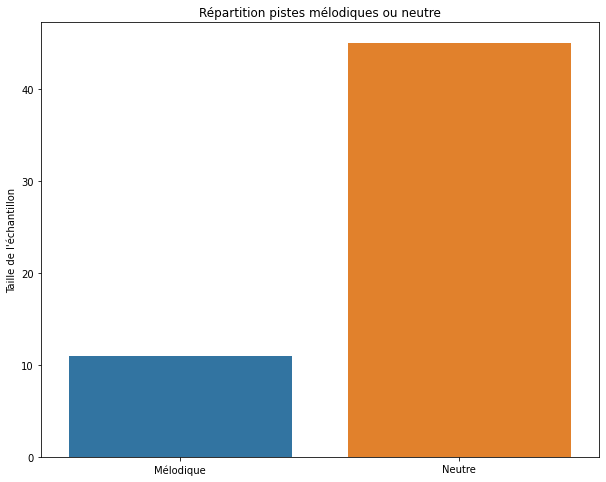

In [24]:
# 11 pistes sont en mélodie, 45 ne sont rien (ni bass, ni mélodie).

plt.figure(figsize=(10,8))
g = sns.barplot(x=df1.value_counts(),y=df1.value_counts()).set_title('Répartition pistes mélodiques ou accompagnement')
plt.ylabel("Taille de l'échantillon")
ax = plt.subplot()
ax = ax.set_xticklabels(["Mélodique","Neutre"])

In [25]:
has_bleed = [i.replace('yes', '1') for i in has_bleed]
has_bleed = [i.replace('no', '0') for i in has_bleed]
df = pd.DataFrame(has_bleed) 

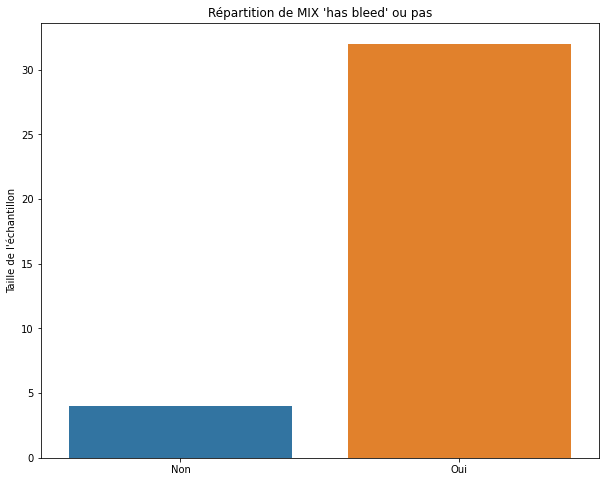

In [26]:
# 32 MIX qui ne sont pas 'has bleed', 4 MIX le sont

plt.figure(figsize=(10,8))
g = sns.barplot(x=df.value_counts(),y=df.value_counts()).set_title("Répartition de MIX 'has bleed' ou pas")
plt.ylabel("Taille de l'échantillon")
ax = plt.subplot()
ax = ax.set_xticklabels(["Non","Oui"])
# save(img_path.joinpath("mon_graphe.png"))

### Modélisation du spectre avec la librairie librosa

In [120]:
# On récupère 2 listes pour pouvoir comparer les spectres de ces 2 types de guitares

electric_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'clean electric guitar')
acoustic_stems = get_instrument_stems(metadata_df["stems"], instrument_name = 'acoustic guitar')

In [151]:
# Recréer le chemin d'accès à la piste choisit aléatoirement

electric_choice = random.choices(electric_stems, k = 3)
print("Nos 3 pistes sont : ", sampling)
clean_sampling_electric = ([s.split("_STEM")[0] for s in electric_choice])
clean_sampling_chiffre_electric = ([s.split("_0")[0] for s in electric_choice])

Nos 3 pistes sont :  ['TablaBreakbeatScience_Vger_STEM_06.wav', 'FacesOnFilm_WaitingForGa_STEM_05.wav', 'Snowmine_Curfews_STEM_08.wav']


In [152]:
liste_pistes_electric = []
for i in range(0,3) :
    liste_pistes_electric.append("D:\Théo\MedleyDB\V1" +'\\'+ str(clean_sampling_electric[i]) +'\\'+ (str(clean_sampling_chiffre_electric[i])+'S') + '\\' + str(electric_choice[i]))
liste_pistes_electric[0]

'D:\\Théo\\MedleyDB\\V1\\TablaBreakbeatScience_Vger\\TablaBreakbeatScience_Vger_STEMS\\TablaBreakbeatScience_Vger_STEM_06.wav'

In [153]:
liste_pistes_electric

['D:\\Théo\\MedleyDB\\V1\\TablaBreakbeatScience_Vger\\TablaBreakbeatScience_Vger_STEMS\\TablaBreakbeatScience_Vger_STEM_06.wav',
 'D:\\Théo\\MedleyDB\\V1\\FacesOnFilm_WaitingForGa\\FacesOnFilm_WaitingForGa_STEMS\\FacesOnFilm_WaitingForGa_STEM_05.wav',
 'D:\\Théo\\MedleyDB\\V1\\Snowmine_Curfews\\Snowmine_Curfews_STEMS\\Snowmine_Curfews_STEM_08.wav']

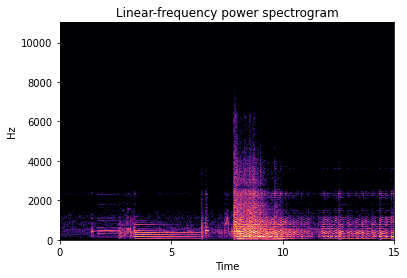

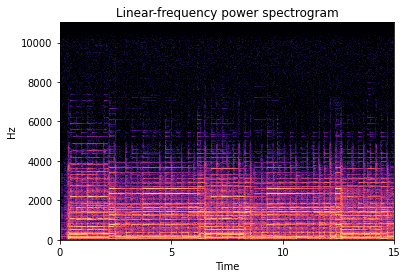

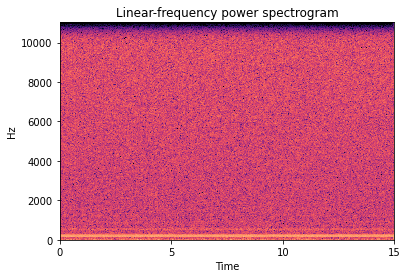

In [154]:
# Modéliser 3 spectres de guitare électrique aléatoirement

for i in liste_pistes_electric :


    y, sr = librosa.load(i, duration=15)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    plt.show()

In [156]:
acoustic_choice = random.choices(acoustic_stems, k = 3)
print("Nos 3 pistes sont : ", sampling)
clean_sampling_acoustic = ([s.split("_STEM")[0] for s in acoustic_choice])
clean_sampling_chiffre_acoustic = ([s.split("_0")[0] for s in acoustic_choice])

Nos 3 pistes sont :  ['KarimDouaidy_Yatora_STEM_02.wav', 'AimeeNorwich_Child_STEM_07.wav', 'MusicDelta_Beatles_STEM_05.wav']


In [160]:
liste_pistes_acoustic = []
for i in range(0,3) :
    liste_pistes_acoustic.append("D:\Théo\MedleyDB\V1" +'\\'+ str(clean_sampling_acoustic[i]) +'\\'+ (str(clean_sampling_chiffre_acoustic[i])+'S') + '\\' + str(acoustic_choice[i]))

In [162]:
liste_pistes_acoustic

['D:\\Théo\\MedleyDB\\V1\\HezekiahJones_BorrowedHeart\\HezekiahJones_BorrowedHeart_STEMS\\HezekiahJones_BorrowedHeart_STEM_01.wav',
 'D:\\Théo\\MedleyDB\\V1\\KarimDouaidy_Hopscotch\\KarimDouaidy_Hopscotch_STEMS\\KarimDouaidy_Hopscotch_STEM_06.wav',
 'D:\\Théo\\MedleyDB\\V1\\AlexanderRoss_VelvetCurtain\\AlexanderRoss_VelvetCurtain_STEMS\\AlexanderRoss_VelvetCurtain_STEM_01.wav']

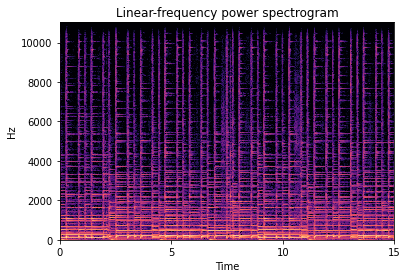

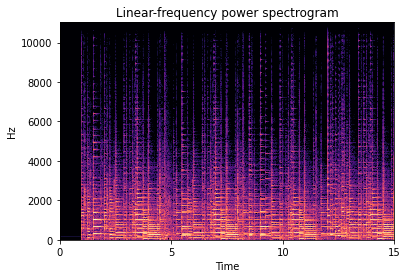

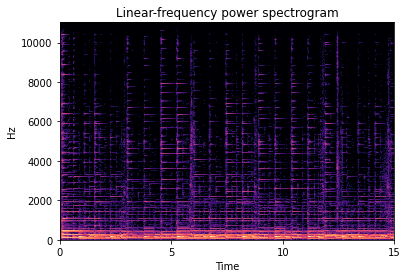

In [163]:
for i in liste_pistes_acoustic :


    y, sr = librosa.load(i, duration=15)
    fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True)
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                                sr=sr, ax=ax)
    ax.set(title='Linear-frequency power spectrogram')
    ax.label_outer()
    plt.show()